# Load packages

In [1]:
import sys
import os
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler

import scrublet as scr
import scipy.io
import time
import collections

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

import logging

from rpy2.robjects import pandas2ri
import anndata2ri

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# ignore R warning messages
#rcb.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

/tmp/ipykernel_520/4258212210.py:6: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.1.0
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
cairo                       1.26.0
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
comm                        0.2.1
cupy                        12.3.0
cupy_backends               NA
cupyx                       NA
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.3
dask                        2023.11.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0

In [3]:
%%R
library(SoupX)
library(Matrix)
library(Seurat)
library(sctransform)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following object is masked from ‘package:base’:

    intersect

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Filenames

In [4]:
os.chdir('/root/host_home')


In [5]:
#Filnames scanpy AnnData for hp NPC samples
adata_hp_input_1 = 'hp_NPCs/raw_data/raw/128_set1_raw_feature_bc_matrix.h5'
adata_hp_input_2 = 'hp_NPCs/raw_data/raw/129_set1_raw_feature_bc_matrix.h5'
adata_hp_input_3 = 'hp_NPCs/raw_data/raw/130_set1_raw_feature_bc_matrix.h5'
adata_hp_input_4 = 'hp_NPCs/raw_data/raw/131_set2_raw_feature_bc_matrix.h5'
adata_hp_input_5 = 'hp_NPCs/raw_data/raw/132_set2_raw_feature_bc_matrix.h5'
adata_hp_input_6 = 'hp_NPCs/raw_data/raw/133_set2_raw_feature_bc_matrix.h5'


In [6]:
#Filename scanpy AnnData output for hp NPC after demultiplexing
adata_out = 'hp_NPCs/processed_data/hp_NPC_filtered_cuda_soup.h5ad'

save_dir = 'hp_NPCs/'

# Read in data

In [7]:
adata_hp_1 = sc.read_10x_h5(filename=adata_hp_input_1)
adata_hp_2 = sc.read_10x_h5(filename=adata_hp_input_2)
adata_hp_3 = sc.read_10x_h5(filename=adata_hp_input_3)
adata_hp_4 = sc.read_10x_h5(filename=adata_hp_input_4)
adata_hp_5 = sc.read_10x_h5(filename=adata_hp_input_5)
adata_hp_6 = sc.read_10x_h5(filename=adata_hp_input_6)

reading hp_NPCs/raw_data/raw/128_set1_raw_feature_bc_matrix.h5
 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/129_set1_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/130_set1_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/131_set2_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/132_set2_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/133_set2_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
adata_hp_1.var['gene_symbols'] = adata_hp_1.var_names
adata_hp_2.var['gene_symbols'] = adata_hp_2.var_names
adata_hp_3.var['gene_symbols'] = adata_hp_3.var_names
adata_hp_4.var['gene_symbols'] = adata_hp_4.var_names
adata_hp_5.var['gene_symbols'] = adata_hp_5.var_names
adata_hp_6.var['gene_symbols'] = adata_hp_6.var_names

In [9]:
adata_hp_1.var_names_make_unique()
adata_hp_2.var_names_make_unique()
adata_hp_3.var_names_make_unique()
adata_hp_4.var_names_make_unique()
adata_hp_5.var_names_make_unique()
adata_hp_6.var_names_make_unique()

# Subset to published dataset and add obs

In [10]:
adata_hp_1.obs_names = adata_hp_1.obs_names.str.split('-').str[0]
adata_hp_2.obs_names = adata_hp_2.obs_names.str.split('-').str[0]
adata_hp_3.obs_names = adata_hp_3.obs_names.str.split('-').str[0]
adata_hp_4.obs_names = adata_hp_4.obs_names.str.split('-').str[0]
adata_hp_5.obs_names = adata_hp_5.obs_names.str.split('-').str[0]
adata_hp_6.obs_names = adata_hp_6.obs_names.str.split('-').str[0]

In [11]:
adata_hp = adata_hp_1.concatenate(adata_hp_2, adata_hp_3, adata_hp_4, adata_hp_5, adata_hp_6, batch_key = 'lane', batch_categories = ['128', '129', '130', '131', '132', '133'])
adata_hp
adata_hp.obs

/tmp/ipykernel_520/3893765964.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_hp = adata_hp_1.concatenate(adata_hp_2, adata_hp_3, adata_hp_4, adata_hp_5, adata_hp_6, batch_key = 'lane', batch_categories = ['128', '129', '130', '131', '132', '133'])


AnnData object with n_obs × n_vars = 4060211 × 20682
    obs: 'lane'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

,lane
AAACCTGAGAAACCAT-128,128
AAACCTGAGAAACCGC-128,128
AAACCTGAGAAACCTA-128,128
AAACCTGAGAAACGAG-128,128
AAACCTGAGAAACGCC-128,128
...,...
TTTGTCATCTTTACAC-133,133
TTTGTCATCTTTACGT-133,133
TTTGTCATCTTTAGGG-133,133
TTTGTCATCTTTAGTC-133,133


In [12]:
adata_geo = sc.read('hp_NPCs/malte_notebooks_hp/ipsc_ipd_patients_final.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/usr/local/lib/python3.10/dist-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [13]:
adata_geo

AnnData object with n_obs × n_vars = 30557 × 24920
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr', 'louvain_final_abbrev'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'gender_colors', 'louvain', 'louvain_final_abbrev_colors', 'louvai

In [14]:
adata_geo.obs
adata_geo.var

,Demux_state,Donor,Lane,Number of genes,Total counts,age,condition,donor,gender,log_counts,...,Apoptosis_pos_corr,Apoptosis_neg_raw,Apoptosis_neg_corr,Necroptosis_pos_raw,Necroptosis_pos_corr,Autophagy_pos_raw,Autophagy_pos_corr,Pathanatos_pos_raw,Pathanatos_pos_corr,louvain_final_abbrev
AAACCTGTCTTGTACT,SNG,UKERiJ2C-R1-015,1,4590,20477.0,73,Parkinson,0,M,9.927057,...,-0.000980,-0.094946,-0.002153,-0.028168,-0.000327,-0.047514,-0.000558,-0.848493,-0.009510,NCSC
AAACGGGTCGTTACAG,SNG,UKERiJ2C-R1-015,1,4068,15318.0,73,Parkinson,0,M,9.636784,...,-0.001796,0.357170,0.003359,-0.040477,-0.000232,-0.016824,0.000036,-0.335042,-0.002842,NSC2a
AAAGATGCAAGCCCAC,SNG,UKERiJ2C-R1-015,1,1195,3693.0,73,Parkinson,0,M,8.214194,...,0.001030,-0.099151,-0.002281,-0.036934,-0.000440,-0.086179,-0.000587,0.055398,0.002199,Apop. NSC
AAAGATGCAATCGGTT,SNG,UKERiJ2C-R1-015,1,4675,21941.0,73,Parkinson,0,M,9.996112,...,-0.005556,0.036673,-0.001205,-0.014622,-0.000315,-0.044574,-0.000408,-0.118669,-0.001033,NSC1a
AAAGCAAAGAGTCGGT,SNG,UKERiJ2C-R1-015,1,3521,12182.0,73,Parkinson,0,M,9.407715,...,-0.003353,0.154093,0.001044,-0.028880,-0.000184,-0.205967,-0.001889,-0.557057,-0.005632,NSC1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCGAAGTCGGAATCT,SNG,UKERi82A-R1-002,6,3601,12922.0,66,Control,11,F,9.466686,...,-0.000655,0.298885,0.004119,-0.014711,-0.000480,0.084356,-0.000003,0.146257,0.000891,NSC2a
TTCTACACACATAACC,SNG,UKERi82A-R1-002,6,2690,7042.0,66,Control,11,F,8.859648,...,-0.002280,-0.224351,-0.002322,-0.038772,-0.000250,-0.144278,-0.001749,-0.052589,-0.001137,NSC2a
TTCTCCTTCTTCTGGC,SNG,UKERi82A-R1-002,6,3033,7998.0,66,Control,11,F,8.986947,...,-0.001688,0.389648,0.006499,-0.043605,0.000144,0.135875,0.001628,0.021245,-0.000093,NSC1b
TTGACTTAGCATCATC,SNG,UKERi82A-R1-002,6,2762,7697.0,66,Control,11,F,8.948586,...,-0.009634,-0.184432,-0.002952,0.000000,-0.000605,-0.183094,-0.001732,-0.944976,-0.014210,NSC2a


,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,0.000002,0.051188,0.930179
CICP27,False,0.000024,0.006907,0.063974
AL627309.6,False,0.000040,0.012598,1.214376
AL627309.5,False,0.000038,0.007326,0.166109
FO538757.1,True,0.000011,0.024521,1.866538
...,...,...,...,...
AC011043.1,True,0.003896,0.003310,3.731811
AL592183.1,False,-0.000194,-0.016039,0.095998
AC007325.4,False,0.000695,0.010819,0.862108
AC004556.1,False,-0.001148,-0.015315,0.139855


In [15]:
adata_1 = adata_geo[adata_geo.obs['Lane'] == '1']
adata_2 = adata_geo[adata_geo.obs['Lane'] == '2']
adata_3 = adata_geo[adata_geo.obs['Lane'] == '3']
adata_4 = adata_geo[adata_geo.obs['Lane'] == '4']
adata_5 = adata_geo[adata_geo.obs['Lane'] == '5']
adata_6 = adata_geo[adata_geo.obs['Lane'] == '6']

In [16]:
adata_1.obs_names = adata_1.obs_names.str.split('_').str[0]
adata_2.obs_names = adata_2.obs_names.str.split('_').str[0]
adata_3.obs_names = adata_3.obs_names.str.split('_').str[0]
adata_4.obs_names = adata_4.obs_names.str.split('_').str[0]
adata_5.obs_names = adata_5.obs_names.str.split('_').str[0]
adata_6.obs_names = adata_6.obs_names.str.split('_').str[0]

In [17]:
adata_geo = adata_1.concatenate(adata_2, adata_3, adata_4, adata_5, adata_6, batch_key = 'lane', batch_categories = ['128', '129', '130', '131', '132', '133'])
adata_geo
adata_geo.obs

/tmp/ipykernel_520/3151462156.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_geo = adata_1.concatenate(adata_2, adata_3, adata_4, adata_5, adata_6, batch_key = 'lane', batch_categories = ['128', '129', '130', '131', '132', '133'])


AnnData object with n_obs × n_vars = 30557 × 24920
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr', 'louvain_final_abbrev', 'lane'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

,Demux_state,Donor,Lane,Number of genes,Total counts,age,condition,donor,gender,log_counts,...,Apoptosis_neg_raw,Apoptosis_neg_corr,Necroptosis_pos_raw,Necroptosis_pos_corr,Autophagy_pos_raw,Autophagy_pos_corr,Pathanatos_pos_raw,Pathanatos_pos_corr,louvain_final_abbrev,lane
AAACCTGTCTTGTACT-128,SNG,UKERiJ2C-R1-015,1,4590,20477.0,73,Parkinson,0,M,9.927057,...,-0.094946,-0.002153,-0.028168,-0.000327,-0.047514,-0.000558,-0.848493,-0.009510,NCSC,128
AAACGGGTCGTTACAG-128,SNG,UKERiJ2C-R1-015,1,4068,15318.0,73,Parkinson,0,M,9.636784,...,0.357170,0.003359,-0.040477,-0.000232,-0.016824,0.000036,-0.335042,-0.002842,NSC2a,128
AAAGATGCAAGCCCAC-128,SNG,UKERiJ2C-R1-015,1,1195,3693.0,73,Parkinson,0,M,8.214194,...,-0.099151,-0.002281,-0.036934,-0.000440,-0.086179,-0.000587,0.055398,0.002199,Apop. NSC,128
AAAGATGCAATCGGTT-128,SNG,UKERiJ2C-R1-015,1,4675,21941.0,73,Parkinson,0,M,9.996112,...,0.036673,-0.001205,-0.014622,-0.000315,-0.044574,-0.000408,-0.118669,-0.001033,NSC1a,128
AAAGCAAAGAGTCGGT-128,SNG,UKERiJ2C-R1-015,1,3521,12182.0,73,Parkinson,0,M,9.407715,...,0.154093,0.001044,-0.028880,-0.000184,-0.205967,-0.001889,-0.557057,-0.005632,NSC1a,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCGAAGTCGGAATCT-133,SNG,UKERi82A-R1-002,6,3601,12922.0,66,Control,11,F,9.466686,...,0.298885,0.004119,-0.014711,-0.000480,0.084356,-0.000003,0.146257,0.000891,NSC2a,133
TTCTACACACATAACC-133,SNG,UKERi82A-R1-002,6,2690,7042.0,66,Control,11,F,8.859648,...,-0.224351,-0.002322,-0.038772,-0.000250,-0.144278,-0.001749,-0.052589,-0.001137,NSC2a,133
TTCTCCTTCTTCTGGC-133,SNG,UKERi82A-R1-002,6,3033,7998.0,66,Control,11,F,8.986947,...,0.389648,0.006499,-0.043605,0.000144,0.135875,0.001628,0.021245,-0.000093,NSC1b,133
TTGACTTAGCATCATC-133,SNG,UKERi82A-R1-002,6,2762,7697.0,66,Control,11,F,8.948586,...,-0.184432,-0.002952,0.000000,-0.000605,-0.183094,-0.001732,-0.944976,-0.014210,NSC2a,133


In [18]:
adata_hp = adata_hp[adata_hp.obs_names.isin(adata_geo.obs_names)]
adata_hp

View of AnnData object with n_obs × n_vars = 30557 × 20682
    obs: 'lane'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [19]:
adata_hp.obs["Demux_state"] = adata_geo.obs['Demux_state']
adata_hp.obs['Donor'] = adata_geo.obs['Donor']
adata_hp.obs['cell_types'] = adata_geo.obs['louvain_final']
adata_hp.obs

/tmp/ipykernel_520/2860089671.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_hp.obs["Demux_state"] = adata_geo.obs['Demux_state']


,lane,Demux_state,Donor,cell_types
AAACCTGCACGTCTCT-128,128,SNG,UKERi1E4-R1-003,NCSC
AAACCTGCAGTATCTG-128,128,SNG,UKERiO3H-R1-005,NSC1a
AAACCTGTCCAGTATG-128,128,SNG,UKERi88H-R1-002,NSC2a
AAACCTGTCCCAACGG-128,128,SNG,UKERiG3G-R1-039,NSC1a
AAACCTGTCCCGGATG-128,128,SNG,UKERi1E4-R1-003,NCSC
...,...,...,...,...
TTTGTCAGTGTAACGG-133,133,SNG,UKERiC99-R1-007,NSC1b
TTTGTCAGTTCTCATT-133,133,SNG,UKERi88H-R1-002,NCSC
TTTGTCATCAGCAACT-133,133,SNG,UKERiC99-R1-007,Glial precursors
TTTGTCATCTACGAGT-133,133,SNG,UKERiAY6-R1-003,NSC1a


In [20]:
adata_hp.obs['cell_types'].cat.categories

Index(['Glial precursors', 'Immature neurons', 'NCSC', 'NSC1a', 'NSC1b',
       'NSC2a', 'NSC2b', 'Apop. NCSC', 'Apop. NSC'],
      dtype='object')

# Add Donor information from demuxlet

In [21]:
Ctrl = ['UKERi1JF-R1-018', 'UKERiG3G-R1-039', 'UKERi1E4-R1-003', 'UKERiO3H-R1-005', 'UKERi82A-R1-002']
sPD = ['UKERiJ2C-R1-015', 'UKERiM89-R1-005', 'UKERiC99-R1-007', 'UKERiR66-R1-007', 'UKERiAY6-R1-003', 'UKERiPX7-R1-001', 'UKERi88H-R1-002']
alld = Ctrl + sPD

In [22]:
#Add condition (either 'Control' or 'Parkinson') to obs
adata_hp.obs['condition'] = np.where(adata_hp.obs['Donor'].isin(Ctrl), 'Control', 'Parkinson')

#Add age of biopsy to obs
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi1JF-R1-018'), 'age'] = 42
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiG3G-R1-039'), 'age'] = 69
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi1E4-R1-003'), 'age'] = 53
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiO3H-R1-005'), 'age'] = 71
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi82A-R1-002'), 'age'] = 66

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'age'] = 73
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiM89-R1-005'), 'age'] = 64
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiC99-R1-007'), 'age'] = 68
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiR66-R1-007'), 'age'] = 54
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiAY6-R1-003'), 'age'] = 37
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiPX7-R1-001'), 'age'] = 49
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi88H-R1-002'), 'age'] = 63

#Add years of illness at biopsy to obs
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'years_of_illness'] = 3
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiM89-R1-005'), 'years_of_illness'] = 3
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiC99-R1-007'), 'years_of_illness'] = 7
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiR66-R1-007'), 'years_of_illness'] = 3
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiAY6-R1-003'), 'years_of_illness'] = 4
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiPX7-R1-001'), 'years_of_illness'] = 1
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi88H-R1-002'), 'years_of_illness'] = 6

#Add disease progression rates
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaHY'] = 3
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaHY'] = 3
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaHY'] = 2.5

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaHY'] = 1
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaHY'] = 1
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaHY'] = 2

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaUPDRS'] = 24
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaUPDRS'] = 53
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaUPDRS'] = 36

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaUPDRS'] = -1
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaUPDRS'] = 0
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaUPDRS'] = 7

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaADL'] = -0.6
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaADL'] = -0.6
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaADL'] = -0.5

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaADL'] = -0.2
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaADL'] = -0.1
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaADL'] = -0.3

#Add increase in required L-Dopa medication 
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiJ2C-R1-015'), 'deltaDOPA'] = 400
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiM89-R1-005'), 'deltaDOPA'] = 1563
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiC99-R1-007'), 'deltaDOPA'] = 610

adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiAY6-R1-003'), 'deltaDOPA'] = 800
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERiPX7-R1-001'), 'deltaDOPA'] = 1900
adata_hp.obs.loc[(adata_hp.obs['Donor'] == 'UKERi88H-R1-002'), 'deltaDOPA'] = 640


#Add Donor gender (either 'M' or 'F') to obs
female = ['UKERi88H-R1-002', 'UKERiG3G-R1-039', 'UKERi82A-R1-002']
adata_hp.obs['gender'] = np.where(adata_hp.obs['Donor'].isin(female), 'F', 'M')

#Add cultivation period (either 'lp' or 'hp') to obs
adata_hp.obs['cultivation_period'] = 'hp'

#Only keep sPD Donor cells in list
adata_hp = adata_hp[adata_hp.obs['Donor'].isin(alld)]

In [23]:
adata_hp
adata_hp.obs
adata_hp.var

View of AnnData object with n_obs × n_vars = 30557 × 20682
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

,lane,Demux_state,Donor,cell_types,condition,age,years_of_illness,deltaHY,deltaUPDRS,deltaADL,deltaDOPA,gender,cultivation_period
AAACCTGCACGTCTCT-128,128,SNG,UKERi1E4-R1-003,NCSC,Control,53.0,NaN,NaN,NaN,NaN,NaN,M,hp
AAACCTGCAGTATCTG-128,128,SNG,UKERiO3H-R1-005,NSC1a,Control,71.0,NaN,NaN,NaN,NaN,NaN,M,hp
AAACCTGTCCAGTATG-128,128,SNG,UKERi88H-R1-002,NSC2a,Parkinson,63.0,6.0,2.0,7.0,-0.3,640.0,F,hp
AAACCTGTCCCAACGG-128,128,SNG,UKERiG3G-R1-039,NSC1a,Control,69.0,NaN,NaN,NaN,NaN,NaN,F,hp
AAACCTGTCCCGGATG-128,128,SNG,UKERi1E4-R1-003,NCSC,Control,53.0,NaN,NaN,NaN,NaN,NaN,M,hp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGTAACGG-133,133,SNG,UKERiC99-R1-007,NSC1b,Parkinson,68.0,7.0,2.5,36.0,-0.5,610.0,M,hp
TTTGTCAGTTCTCATT-133,133,SNG,UKERi88H-R1-002,NCSC,Parkinson,63.0,6.0,2.0,7.0,-0.3,640.0,F,hp
TTTGTCATCAGCAACT-133,133,SNG,UKERiC99-R1-007,Glial precursors,Parkinson,68.0,7.0,2.5,36.0,-0.5,610.0,M,hp
TTTGTCATCTACGAGT-133,133,SNG,UKERiAY6-R1-003,NSC1a,Parkinson,37.0,4.0,1.0,-1.0,-0.2,800.0,M,hp


,gene_ids,feature_types,genome,gene_symbols
ATAD3B,ENSG00000160072,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ATAD3B
PRDM16,ENSG00000142611,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PRDM16
PEX10,ENSG00000157911,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PEX10
PEX14,ENSG00000142655,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PEX14
PLCH2,ENSG00000149527,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PLCH2
...,...,...,...,...
ENSG00000275063,ENSG00000275063,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000275063
ENSG00000277856,ENSG00000277856,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000277856
ENSG00000271254,ENSG00000271254,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000271254
ENSG00000268674,ENSG00000268674,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000268674


In [24]:
del adata_geo
del adata_1
del adata_2
del adata_3
del adata_4
del adata_5
del adata_6
del adata_hp_1
del adata_hp_2
del adata_hp_3
del adata_hp_4
del adata_hp_5
del adata_hp_6

# Check metadata

In [25]:
#Check dataset stats
adata_hp
adata_hp.obs['lane'].value_counts()
adata_hp.obs['Demux_state'].value_counts()
adata_hp.obs['Donor'].value_counts()


View of AnnData object with n_obs × n_vars = 30557 × 20682
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

lane
133    5284
132    5278
131    5160
130    5114
129    4911
128    4810
Name: count, dtype: int64

Demux_state
SNG    30557
Name: count, dtype: int64

Donor
UKERiC99-R1-007    4582
UKERi1E4-R1-003    3446
UKERi88H-R1-002    3279
UKERiG3G-R1-039    3232
UKERiAY6-R1-003    2979
UKERiO3H-R1-005    2746
UKERiR66-R1-007    2693
UKERiJ2C-R1-015    2163
UKERiPX7-R1-001    2157
UKERi1JF-R1-018    1394
UKERiM89-R1-005    1034
UKERi82A-R1-002     852
Name: count, dtype: int64

In [26]:
adata_hp.obs.condition.value_counts()
adata_hp.obs.age.value_counts()
adata_hp.obs.years_of_illness.value_counts()
adata_hp.obs.gender.value_counts()

condition
Parkinson    18887
Control      11670
Name: count, dtype: int64

age
68.0    4582
53.0    3446
63.0    3279
69.0    3232
37.0    2979
71.0    2746
54.0    2693
73.0    2163
49.0    2157
42.0    1394
64.0    1034
66.0     852
Name: count, dtype: int64

years_of_illness
3.0    5890
7.0    4582
6.0    3279
4.0    2979
1.0    2157
Name: count, dtype: int64

gender
M    23194
F     7363
Name: count, dtype: int64

# Quality Control - filtering counts, genes, mt fraction

In [27]:
# Quality control - calculate QC covariates

# mitochondrial genes
adata_hp.var['mt'] = adata_hp.var.gene_symbols.str.startswith('MT-')
# ribosomal genes
adata_hp.var['ribo'] = adata_hp.var.gene_symbols.str.startswith(('RPS', 'RPL'))
# hemoglobin genes.
adata_hp.var['hb'] = adata_hp.var.gene_symbols.str.contains(('^HB[^(P)]'))

sc.pp.calculate_qc_metrics(
    adata_hp, qc_vars=['mt', 'ribo', 'hb'], inplace=True, percent_top=[20], log1p=True
)
adata_hp

/tmp/ipykernel_51596/627061209.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_hp.var['mt'] = adata_hp.var.gene_symbols.str.startswith('MT-')


AnnData object with n_obs × n_vars = 30557 × 20682
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [28]:
if not os.path.exists(save_dir+'figures'):
    # Create a new directory because it does not exist
    os.mkdir(save_dir+'figures')
    print("The new directory: "+save_dir+"figures is created!")
else: 
    print("The directory "+save_dir+"figures already exists")

The directory hp_NPCs/figures already exists


In [29]:
if not os.path.exists(save_dir+'figures/QC'):
    # Create a new directory because it does not exist
    os.mkdir(save_dir+'figures/QC')
    print("The new directory: "+save_dir+"figures/QC is created!")
else: 
    print("The directory "+save_dir+"figures/QC already exists")

The directory hp_NPCs/figures/QC already exists


## Visualize stats for combined dataset

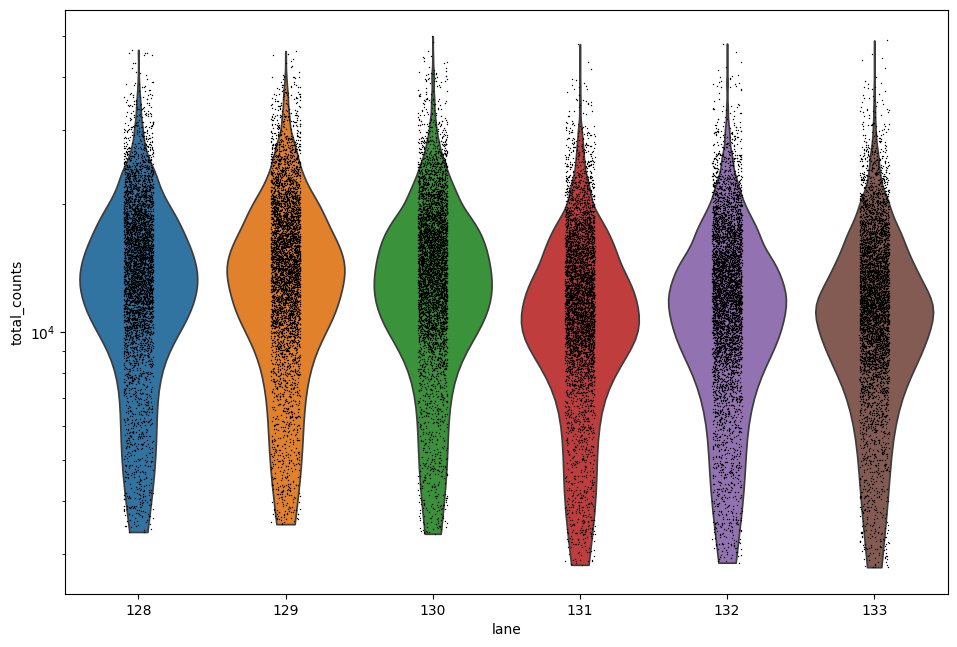

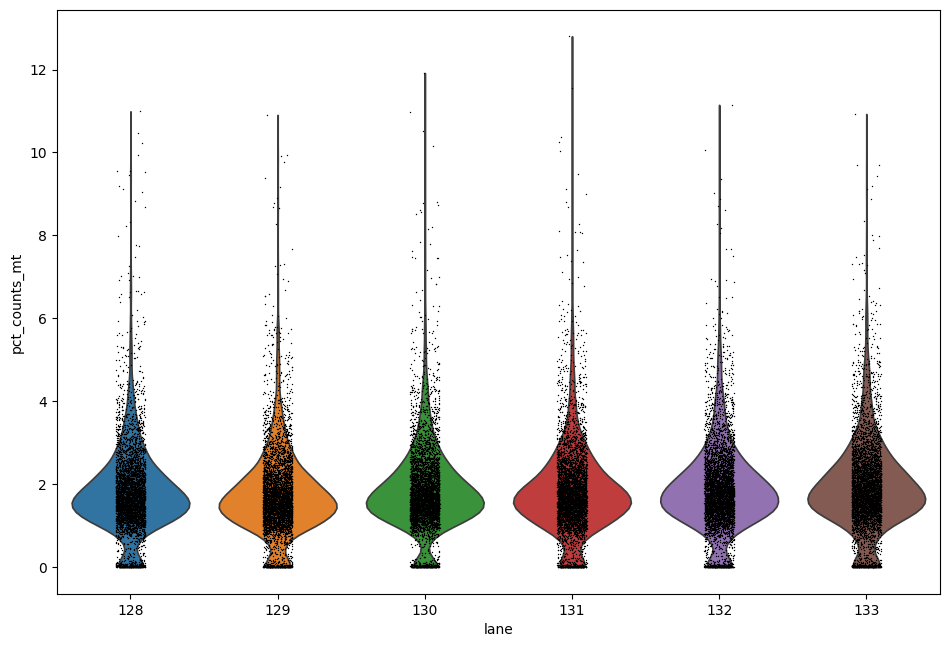

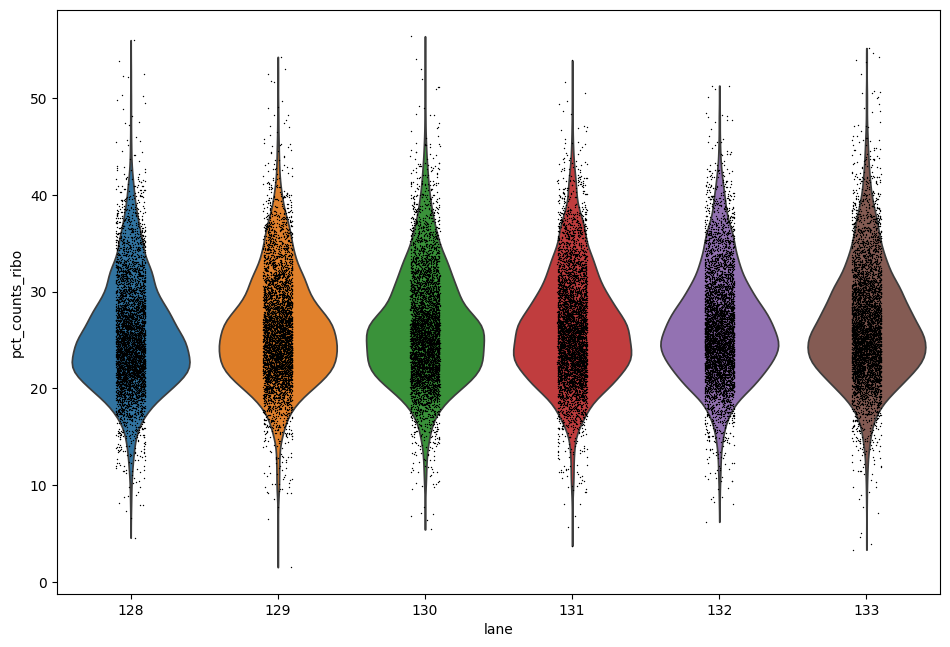

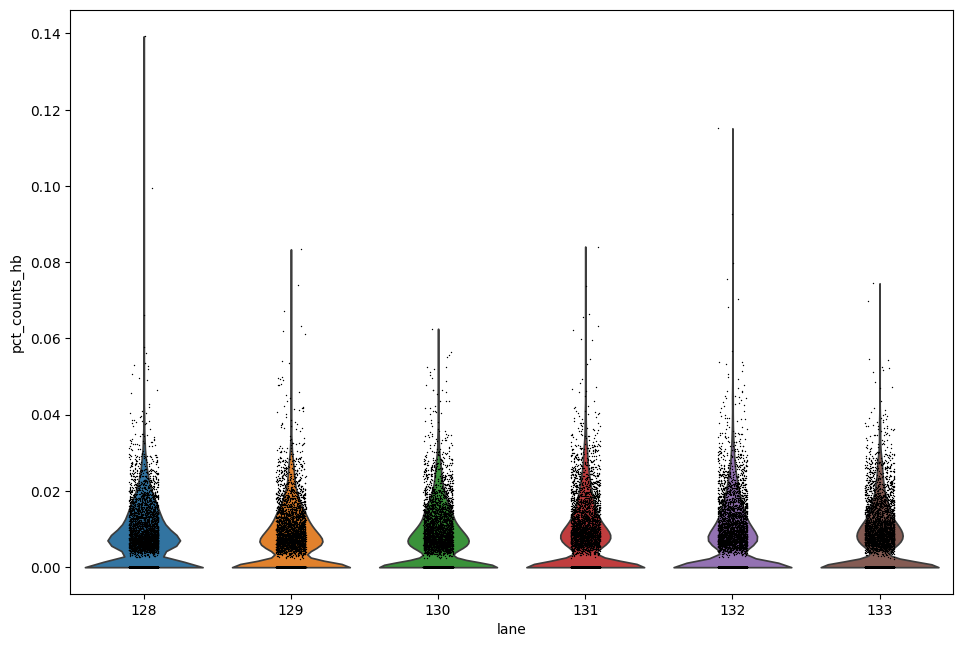

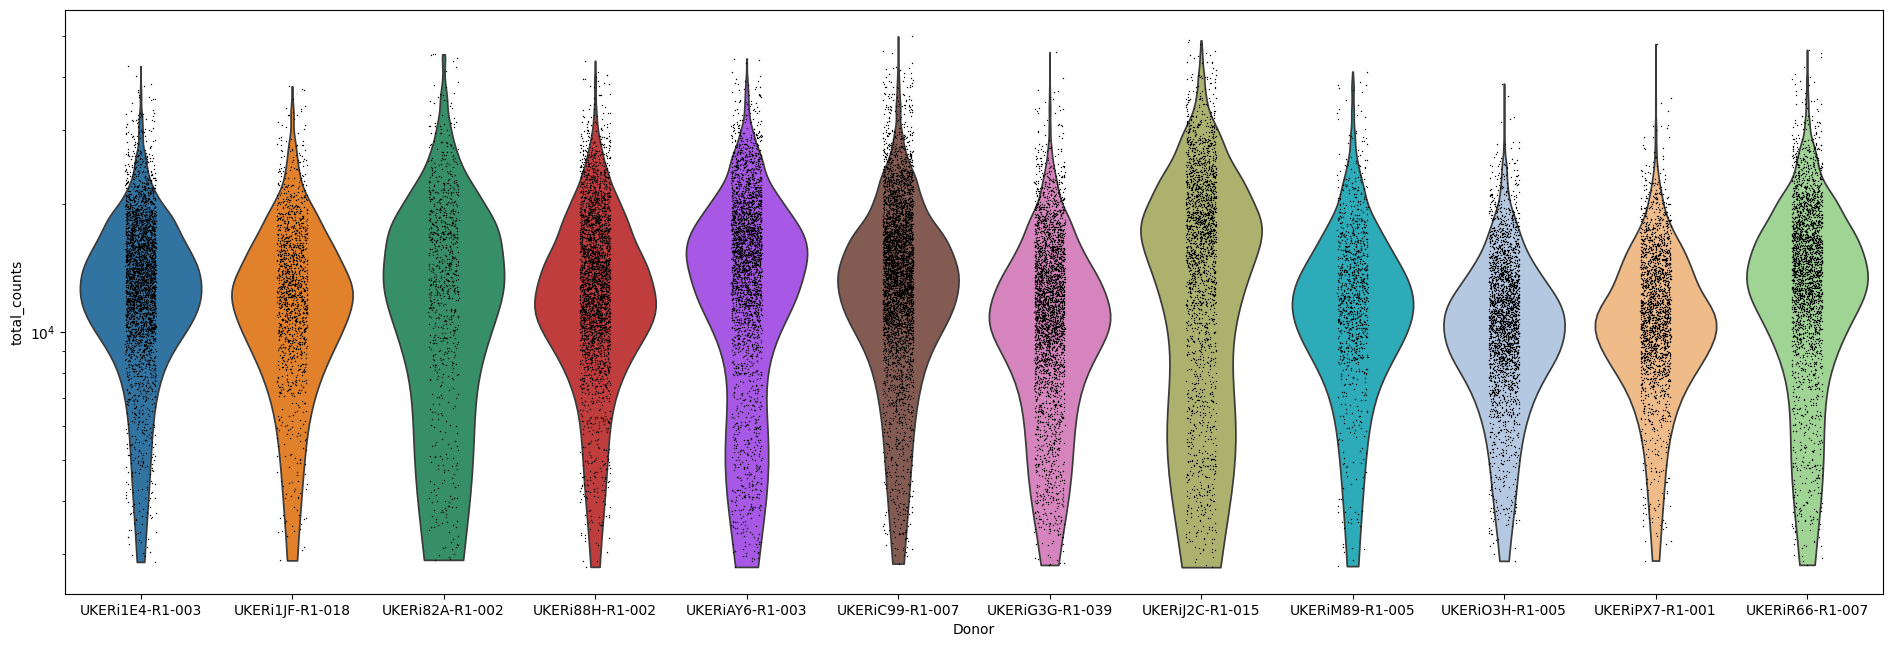

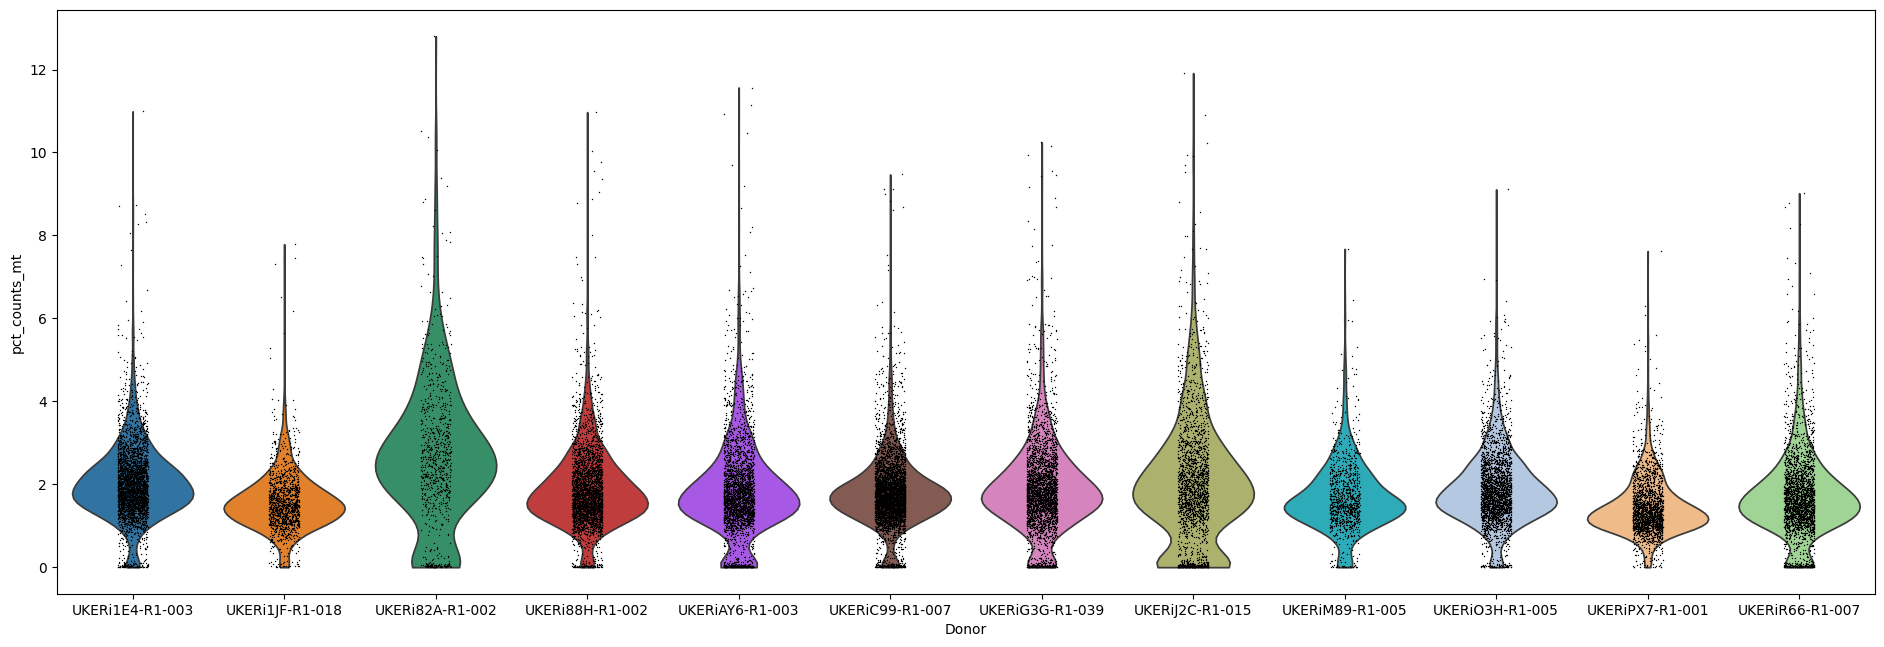

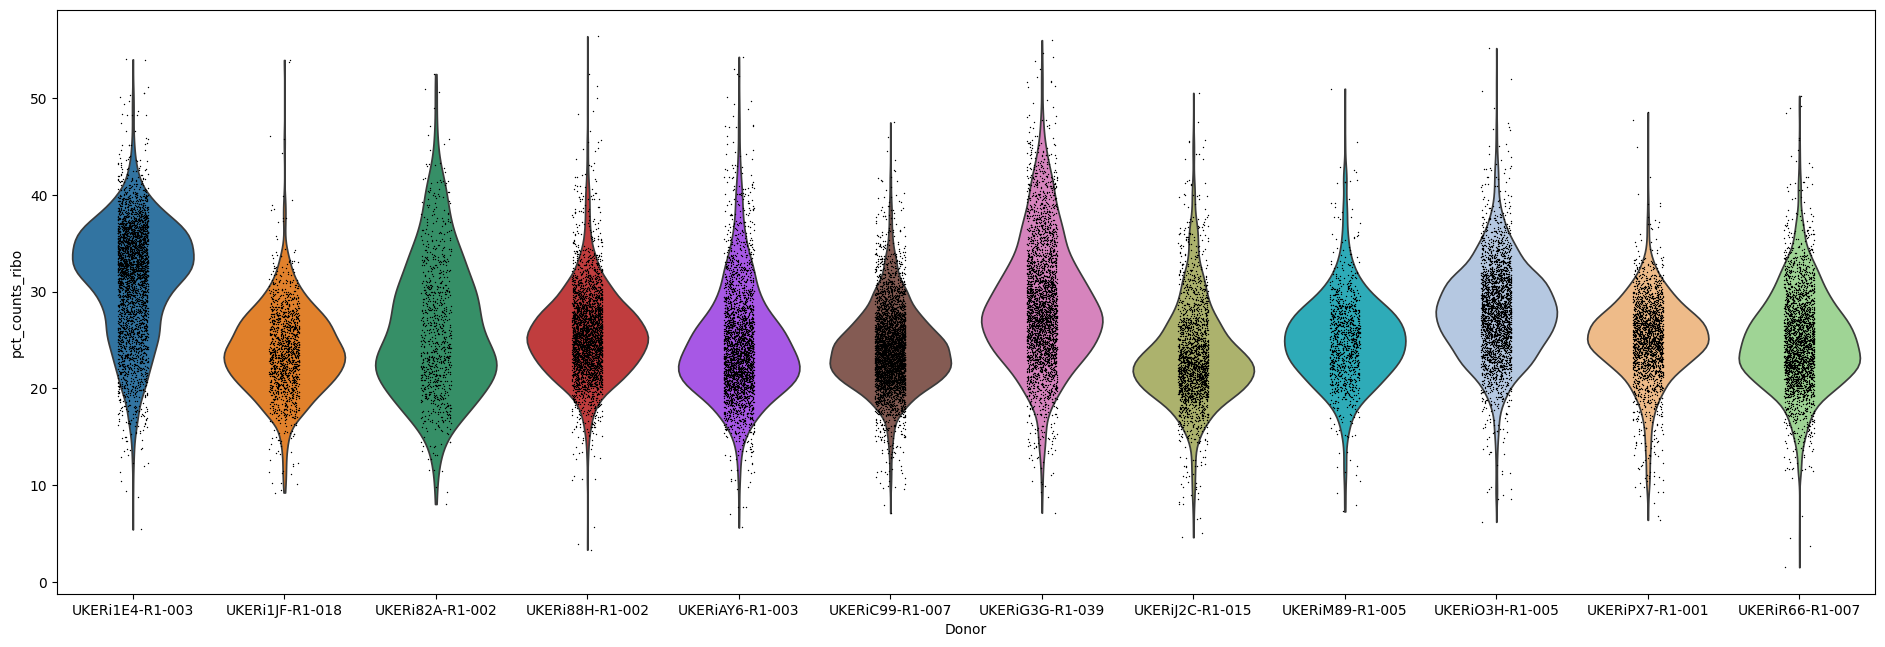

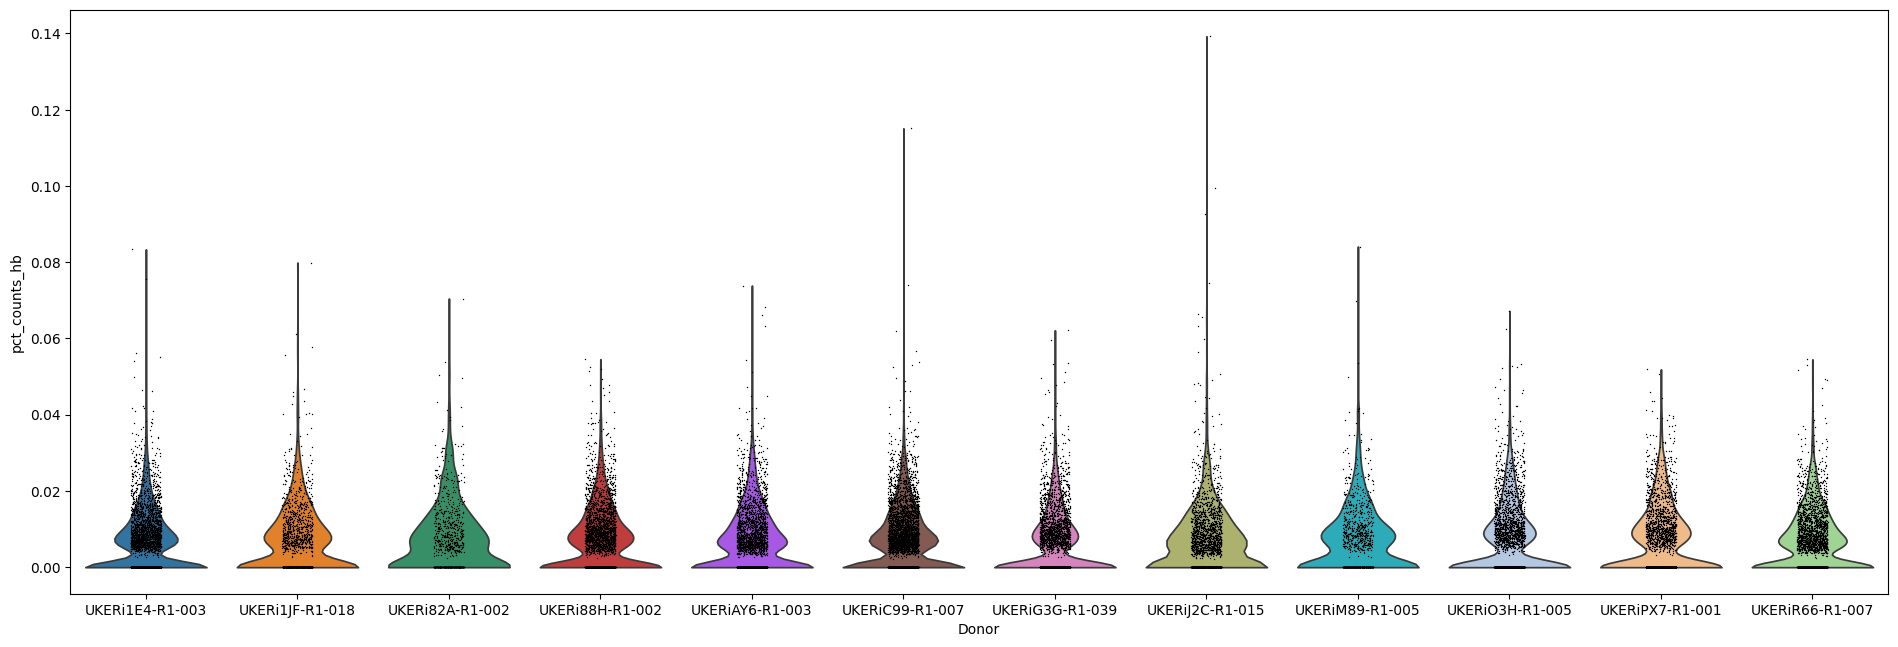

In [30]:
#Sample quality plots
plt.rcParams['figure.figsize']=(9.5,8) #rescale figures
t1 = sc.pl.violin(adata_hp, 'total_counts', groupby='lane', log=True, cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Lanes_violin_total_counts.svg')

plt.rcParams['figure.figsize']=(9.5,8) #rescale figures
t2 = sc.pl.violin(adata_hp, 'pct_counts_mt', groupby='lane', cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Lanes_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata_hp, 'pct_counts_ribo', groupby='lane', cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Lanes_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata_hp, 'pct_counts_hb', groupby='lane', show=False)
plt.savefig('hp_NPCs/figures/QC/Lanes_violin_pct_counts_hb.svg')

plt.rcParams['figure.figsize']=(18,8) #rescale figures
t5 = sc.pl.violin(adata_hp, 'total_counts', groupby='Donor', log=True, cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Donor_violin_total_counts.svg')
t6 = sc.pl.violin(adata_hp, 'pct_counts_mt', groupby='Donor', cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Donor_violin_pct_counts_mt.svg')
t3 = sc.pl.violin(adata_hp, 'pct_counts_ribo', groupby='Donor', cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Donor_violin_pct_counts_ribo.svg')
t4 = sc.pl.violin(adata_hp, 'pct_counts_hb', groupby='Donor', cut=0, show=False)
plt.savefig('hp_NPCs/figures/QC/Donor_violin_pct_counts_hb.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

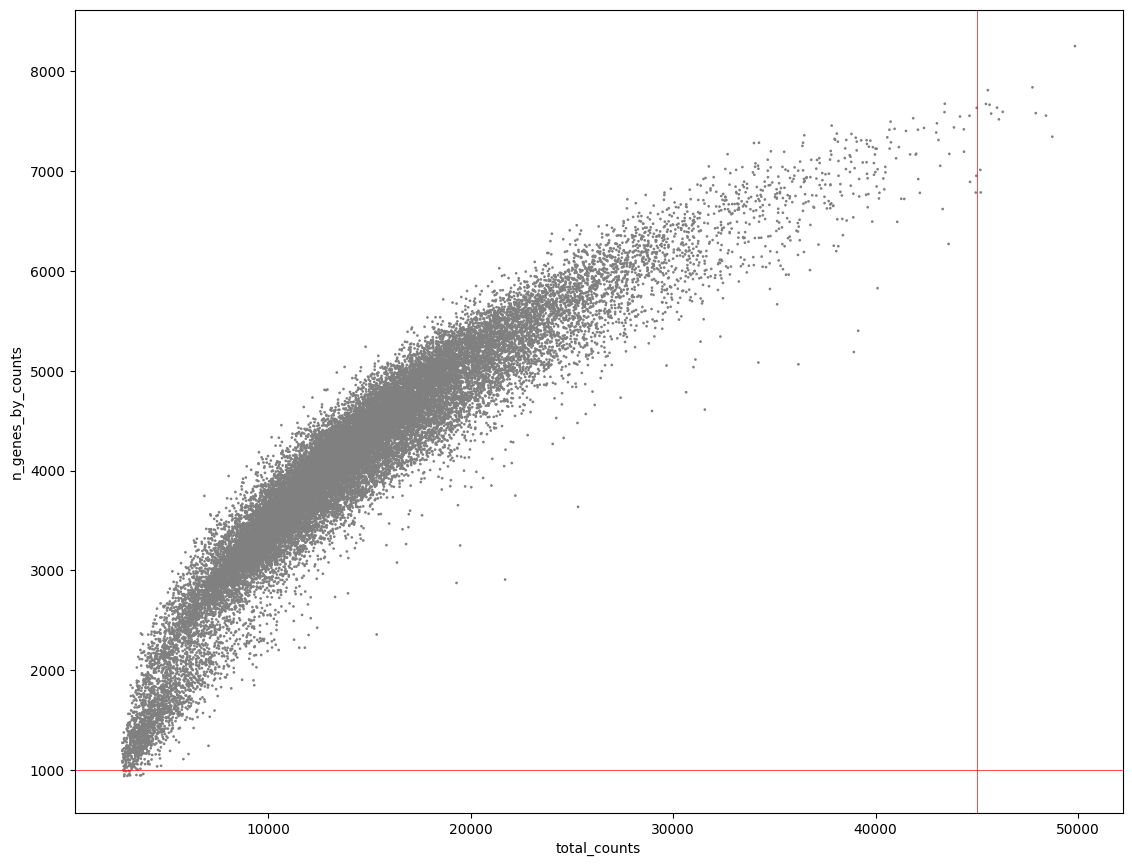

In [31]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0.2, 1, 150))
colors3 = plt.cm.Greys_r(np.linspace(0.5,0.55,30))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# QC plot for manuscript
plt.rcParams['figure.figsize']=(11,11) #rescale figures
p1 = sc.pl.scatter(adata_hp, 'total_counts', 'n_genes_by_counts', show=False, title='', size=15)
p1.axvline(45000,0,9000, color='red', linewidth=0.5)
p1.axhline(1000,0,75000, color='red', linewidth=0.5)
plt.savefig('hp_NPCs/figures/QC/scatter_figure_qcplot_after-filtering.svg')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# Quality Control - Correction of ambient RNA

## Preprocess datasets

In [32]:
a,b = np.unique(adata_hp.obs['lane'], return_index=True)
sample_id = a[np.argsort(b)]
ro.globalenv['sample_id'] = sample_id

In [33]:
adatas =[]
adatas_pp =[]
for sample in enumerate(sample_id):
    print('\n', sample[1], '\n')
    adata_pp = adata_hp[adata_hp.obs['lane']==sample[1]].copy()
    adata = adata_hp[adata_hp.obs['lane']==sample[1]].copy()
    # Preprocess variables for SoupX
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added='soupx_groups')

    # send to R
    ro.globalenv['soupx_groups_'+str(sample[1])] = adata_pp.obs['soupx_groups']   
    ro.globalenv['cells_'+str(sample[1])] = adata.obs_names
    ro.globalenv['genes_'+str(sample[1])] = adata.var_names
    data = adata.X.T
    if sp.sparse.issparse(data):
        if data.nnz > 2**31 - 1:
            data = data.tocoo()
        else:
            data = data.tocsc()
    ro.globalenv['data_'+str(sample[1])] = data
    
    adatas.append(adata)
    adatas_pp.append(adata_pp)
    del adata_pp
    del adata


 128 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:29)
computing neighbors
    using 'X_pca' with n_pcs = 50


2024-05-21 14:04:48.156915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
running Leiden clustering


/tmp/ipykernel_51596/666987564.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added='soupx_groups')


    finished: found 20 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:01)

 129 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:29)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 18 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:01)

 130 

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:28)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.

## Load full dataset

In [34]:
#Filnames scanpy AnnData for raw NPC samples
adata_raw_input_1 = 'hp_NPCs/raw_data/raw/128_set1_raw_feature_bc_matrix.h5'
adata_raw_input_2 = 'hp_NPCs/raw_data/raw/129_set1_raw_feature_bc_matrix.h5'
adata_raw_input_3 = 'hp_NPCs/raw_data/raw/130_set1_raw_feature_bc_matrix.h5'
adata_raw_input_4 = 'hp_NPCs/raw_data/raw/131_set2_raw_feature_bc_matrix.h5'
adata_raw_input_5 = 'hp_NPCs/raw_data/raw/132_set2_raw_feature_bc_matrix.h5'
adata_raw_input_6 = 'hp_NPCs/raw_data/raw/133_set2_raw_feature_bc_matrix.h5'

In [35]:
adata_raw_1 = sc.read_10x_h5(filename=adata_raw_input_1)
adata_raw_2 = sc.read_10x_h5(filename=adata_raw_input_2)
adata_raw_3 = sc.read_10x_h5(filename=adata_raw_input_3)
adata_raw_4 = sc.read_10x_h5(filename=adata_raw_input_4)
adata_raw_5 = sc.read_10x_h5(filename=adata_raw_input_5)
adata_raw_6 = sc.read_10x_h5(filename=adata_raw_input_6)

reading hp_NPCs/raw_data/raw/128_set1_raw_feature_bc_matrix.h5
 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/129_set1_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/130_set1_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/131_set2_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/132_set2_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading hp_NPCs/raw_data/raw/133_set2_raw_feature_bc_matrix.h5


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:02)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [36]:
adata_raw_1.var['gene_symbols'] = adata_raw_1.var_names
adata_raw_2.var['gene_symbols'] = adata_raw_2.var_names
adata_raw_3.var['gene_symbols'] = adata_raw_3.var_names
adata_raw_4.var['gene_symbols'] = adata_raw_4.var_names
adata_raw_5.var['gene_symbols'] = adata_raw_5.var_names
adata_raw_6.var['gene_symbols'] = adata_raw_6.var_names

In [37]:
adata_raw_1.var_names_make_unique()
adata_raw_2.var_names_make_unique()
adata_raw_3.var_names_make_unique()
adata_raw_4.var_names_make_unique()
adata_raw_5.var_names_make_unique()
adata_raw_6.var_names_make_unique()

In [38]:
adata_raw_1.obs_names = adata_raw_1.obs_names.str.split('-').str[0]
adata_raw_2.obs_names = adata_raw_2.obs_names.str.split('-').str[0]
adata_raw_3.obs_names = adata_raw_3.obs_names.str.split('-').str[0]
adata_raw_4.obs_names = adata_raw_4.obs_names.str.split('-').str[0]
adata_raw_5.obs_names = adata_raw_5.obs_names.str.split('-').str[0]
adata_raw_6.obs_names = adata_raw_6.obs_names.str.split('-').str[0]

In [39]:
adata_raw = adata_raw_1.concatenate(adata_raw_2, adata_raw_3, adata_raw_4, adata_raw_5, adata_raw_6, batch_key = 'lane', batch_categories = ['128', '129', '130', '131', '132', '133'])
del adata_raw_1
del adata_raw_2
del adata_raw_3
del adata_raw_4
del adata_raw_5
del adata_raw_6

/tmp/ipykernel_51596/2681520824.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_raw = adata_raw_1.concatenate(adata_raw_2, adata_raw_3, adata_raw_4, adata_raw_5, adata_raw_6, batch_key = 'lane', batch_categories = ['128', '129', '130', '131', '132', '133'])


In [40]:
adata_raw.obs

,lane
AAACCTGAGAAACCAT-128,128
AAACCTGAGAAACCGC-128,128
AAACCTGAGAAACCTA-128,128
AAACCTGAGAAACGAG-128,128
AAACCTGAGAAACGCC-128,128
...,...
TTTGTCATCTTTACAC-133,133
TTTGTCATCTTTACGT-133,133
TTTGTCATCTTTAGGG-133,133
TTTGTCATCTTTAGTC-133,133


In [41]:
adata_raw.var

,gene_ids,feature_types,genome,gene_symbols
ATAD3B,ENSG00000160072,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ATAD3B
PRDM16,ENSG00000142611,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PRDM16
PEX10,ENSG00000157911,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PEX10
PEX14,ENSG00000142655,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PEX14
PLCH2,ENSG00000149527,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,PLCH2
...,...,...,...,...
ENSG00000275063,ENSG00000275063,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000275063
ENSG00000277856,ENSG00000277856,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000277856
ENSG00000271254,ENSG00000271254,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000271254
ENSG00000268674,ENSG00000268674,Gene Expression,homo_sapiens_GRCh38_ensembl_release108_cr7.0.1,ENSG00000268674


In [42]:
adatas_tod =[]
for sample in enumerate(sample_id):
    adata_tod = adata_raw[adata_raw.obs['lane']==sample[1]].copy()
    data_tod = adata_tod.X.T
    if sp.sparse.issparse(data_tod):
        if data_tod.nnz > 2**31 - 1:
            data_tod = data_tod.tocoo()
        else:
            data = data_tod.tocsc()
    # send to R
    ro.globalenv['data_tod_'+str(sample[1])] = data_tod

    adatas_tod.append(adata_tod)
    del adata_tod
    del data

## Run SoupX

In [43]:
%%R

out <- list()

for (sample in sample_id){
    # specify variables
    data = eval(parse(text = paste0('data_', sample)))
    data_tod = eval(parse(text = paste0('data_tod_', sample)))
    genes = eval(parse(text = paste0('genes_', sample)))
    cells = eval(parse(text = paste0('cells_', sample)))
    soupx_groups = eval(parse(text = paste0('soupx_groups_', sample)))
    
    # specify row and column names of data
    rownames(data) = genes
    colnames(data) = cells
    
    # ensure correct sparse format for table of counts and table of droplets
    data <- as(data, 'sparseMatrix')
    data_tod <- as(data_tod, 'sparseMatrix')

    # Generate SoupChannel Object for SoupX 
    sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

    # Add extra meta data to the SoupChannel object
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction
    sc  = autoEstCont(sc, tfidfMin = 0.9, soupQuantile = 0.7, doPlot=FALSE)
    # Infer corrected table of counts and rount to integer
    out[[sample]] = adjustCounts(sc, roundToInt = TRUE)  
    
}

931 genes passed tf-idf cut-off and 246 soup quantile filter.  Taking the top 100.
Using 766 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 20 clusters to 4810 cells.
745 genes passed tf-idf cut-off and 216 soup quantile filter.  Taking the top 100.
Using 663 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 18 clusters to 4911 cells.
768 genes passed tf-idf cut-off and 233 soup quantile filter.  Taking the top 100.
Using 669 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 18 clusters to 5114 cells.
713 genes passed tf-idf cut-off and 225 soup quantile filter.  Taking the top 100.
Using 658 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 18 clusters to 5160 cells.
850 genes passed tf-idf cut-off and 256 soup quantile filter.  Taking the top 100.
Using 721 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 20 clusters to 5278 ce

In [45]:
out = ro.globalenv['out']

In [46]:
%%R
rm(list = ls())

In [47]:
out_list = list(collections.OrderedDict(out).values())


In [48]:
for sample in range(0,6):
    adatas[sample].layers['counts'] = adatas[sample].X
    adatas[sample].layers['soupX_counts'] = out_list[sample].T
    adatas[sample].X = adatas[sample].layers['soupX_counts']

In [49]:
adata_hp = adatas[0].concatenate(adatas[1:], index_unique = None)

/tmp/ipykernel_51596/2435169984.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_hp = adatas[0].concatenate(adatas[1:], index_unique = None)


In [50]:
print(f'Total number of genes: {adata_hp.n_vars}')

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_hp, min_cells=20)
print(f'Number of genes after cell filter: {adata_hp.n_vars}')

Total number of genes: 20682
filtered out 3908 genes that are detected in less than 20 cells
Number of genes after cell filter: 16774


In [51]:
del adata_raw

In [52]:
#adata_hp.write('hp_NPCs/processed_data/hp_NPC_after_soupX.h5ad')

# Write data to file

In [53]:
adata_hp.write(adata_out)

# Visual sanity check

In [54]:
sc.pp.normalize_total(adata_hp,target_sum = 1e4)
sc.pp.log1p(adata_hp)

normalizing counts per cell
    finished (0:00:04)


In [55]:
sc.tl.pca(adata_hp, svd_solver='arpack')
sc.pp.neighbors(adata_hp)

computing PCA
    with n_comps=50
    finished (0:01:37)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)


In [56]:
sc.tl.umap(adata_hp)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [57]:
lane_key = "lane"
donor_key = "Donor"
dataset_key = "cultivation_period"
label_key = "condition"

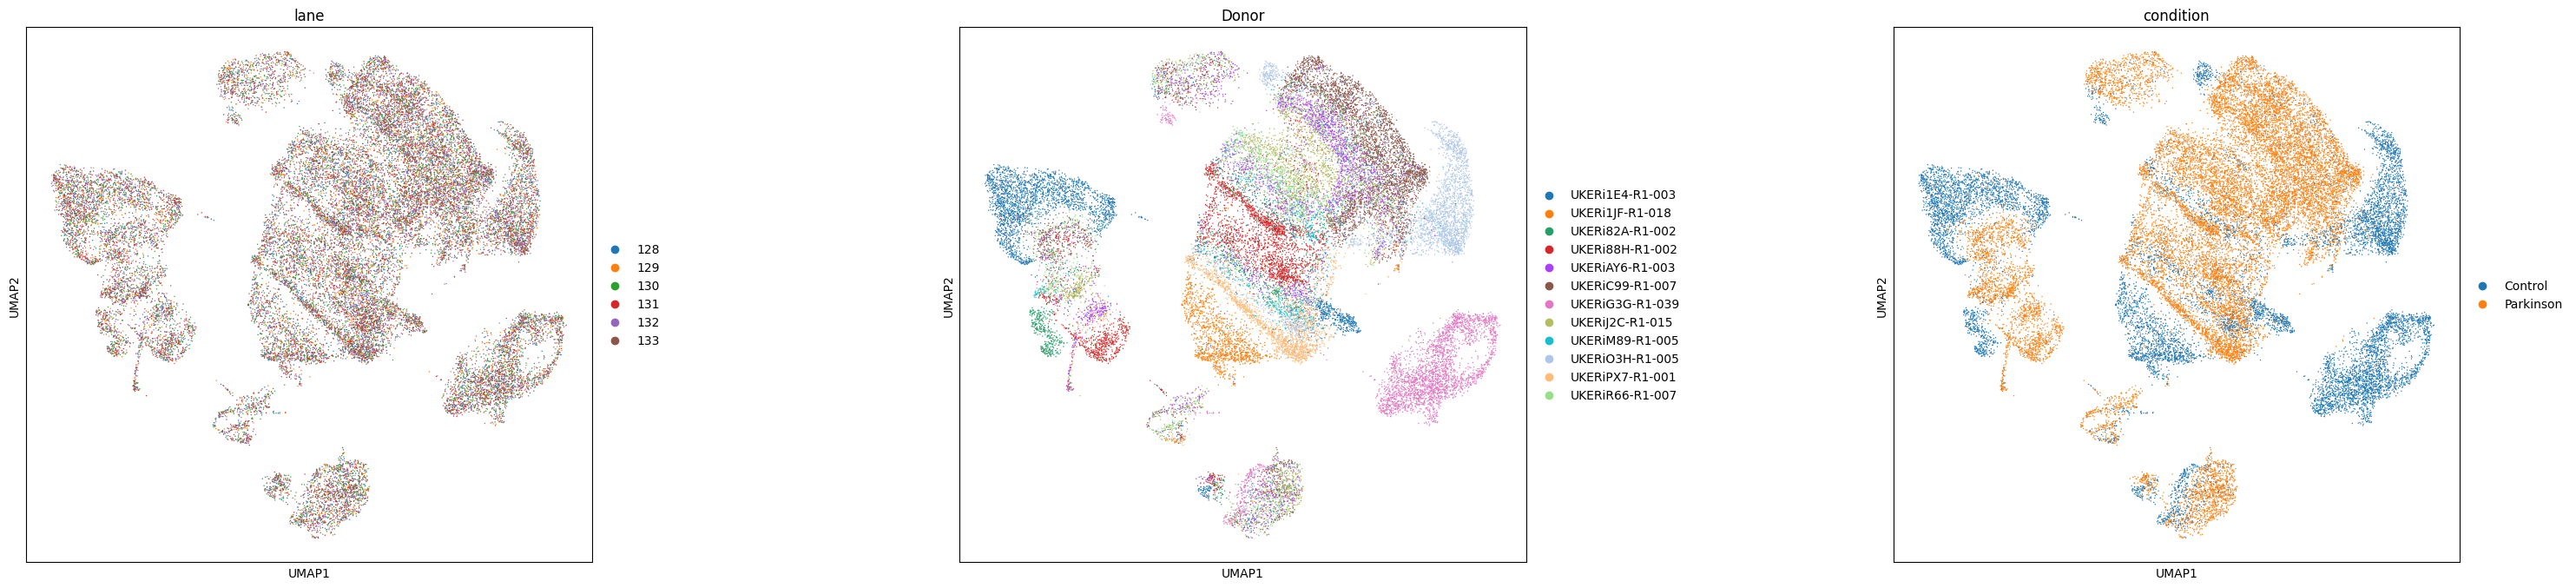

In [58]:
sc.pl.umap(adata_hp, color=[lane_key, donor_key, label_key], wspace = 0.5)

In [25]:
adata_hp.var.to_csv("genes.csv")